## The grid cell system model is a spiking neural network (SNN) model written in pyNEST (2.18)
@author R Stentiford

In this experiment a grid cell attractor network is built using interactions between and excitatory and inhibitory population. Four conjunctive layers driven by the translational velocity drive the activity bump across the sheet

In [1]:
folder = 'rand1_walk_distal'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest as sim
import numpy as np
import pandas
from collections import Counter
import time as tm
import scipy.stats
import pandas as pd
import grid_analysis as griddy
import os

sim.ResetKernel()

mins = 5.
sim_len = int(mins * 60000)
print(f'simulation length: {mins} mins = {sim_len} ms')

simulation length: 5.0 mins = 300000 ms


### Params

In [3]:
y_dim = (0.5* np.sqrt(3))
Nx = 20
Ny = int(np.ceil(Nx * y_dim))
N = Nx * Ny

sigma = 0.5/6 #0.12
mu = 0.5
delay = 0.1
base_ex = 4000
base_in = 450
base_cj = 3800 #3500. #THIS PARAMETER WILL CHANGE THE GRID SCALE
w_ex_cj = 500.

I_init = 300.0 #pA
I_init_dur = 100.0 #ms
I_init_pos = 350

### Create populations

All cells are simulated using pyNEST's standard leaky integrate-and-fire neuron model (iaf_psc_alpha) which uses alpha-function shaped synaptic currents. 

The network is composed of six equally sized rings of neurons: 180 excitatory cells, 180 excitatory cells, 180 of each up, down, left and right conjunctive cells. 

Constant input current of 400 pA to all excitatory neurons results in spontaneous firing.

In [4]:
exc = sim.Create("iaf_psc_alpha",N, params={"I_e": 400.})
inh = sim.Create("iaf_psc_alpha",N)

l = sim.Create("iaf_psc_alpha",N)
r = sim.Create("iaf_psc_alpha",N)
u = sim.Create("iaf_psc_alpha",N)
d = sim.Create("iaf_psc_alpha",N)

### Define connections

Attractor dynamics emerge through reciprocal connections between cells in the excitatory population and inhibitory population. Each excitatory cell connects to a subset of inhibitory neurons with declining synaptic strength as a function of distance. Reciprocal inhibitory connections from each inhibitory cell to excitatory cells are arranged with synaptic strength decreasing as a function of distance offset by a constant (mu).

This arrangement provides inhibitory input to the cells surrounding the most active excitatory cell, producing a single stable bump of activity.

Cells are arranged as 2D sheets with twisted torus wrap around connectivity for the purpose of defining synaptic strength based on distance. See Guanella et al 2007 for a full description of this connectivity structure and the origin of the following calculations.

In [5]:
def twistedTorus(x_e,y_e,x_i,y_i,y_dim):
        d1 = np.sqrt(abs(x_e - x_i)**2 + abs(y_e - y_i)**2)
        d2 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d3 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d4 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d5 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d6 = np.sqrt(abs(x_e - x_i - 1.)**2 + abs(y_e - y_i)**2)
        d7 = np.sqrt(abs(x_e - x_i + 1.)**2 + abs(y_e - y_i)**2)
        
        return min(d1,d2,d3,d4,d5,d6,d7)

In [6]:
w_ex = np.empty((N,N))
w_in = np.empty((N,N))
for e in range(N):
    x_e = (e%Nx) / Nx
    y_e = y_dim*(e//Nx)/ Ny
    for i in range(N): 
        x_i = (i%Nx) / Nx 
        y_i = y_dim*(i//Nx) / Ny
        
        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)

        w_gauss = np.exp(-(d_)**2/2/sigma**2)
        w_ring = np.exp(-(d_ - mu)**2/2/sigma**2)

        w_ex[i,e] = base_ex * w_ring
        w_in[e,i] = base_in * w_gauss

w_ex[w_ex<10]=0
w_in[w_in<10]=0

In order to track translaiton based on velocity the four populations of conjunctive cells are connected one to one with an excitatory cell, shifted one cell u, down, left or right on the sheet from the equivalently positioned neuron.

The same distance dependent calculation is performed, using ofset positions of the inhibitory cell, with only the strongest connection maintained. Due to the twisted torus configuration and the ydim parameter this may be more than one cell with lower weights.

In [7]:
w_l = np.empty((N,N))
w_r = np.empty((N,N))
w_u = np.empty((N,N))
w_d = np.empty((N,N))
for e in range(N):
    x_e = (e%Nx) / Nx
    y_e = (e//Nx) / Ny * y_dim
    for i in range(N): 
        x_i = ((i%Nx) / Nx) - (1/Nx) #shift
        y_i = (i//Nx) / Ny * y_dim

        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_l[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))
        
        x_i = ((i%Nx) / Nx) + (1/Nx) #shift 
        y_i = (i//Nx) / Ny * y_dim

        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_r[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))        

        x_i = (i%Nx) / Nx 
        y_i = ((i//Nx) / Ny * y_dim) + (1 / Ny * y_dim)  #shift

        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_u[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))
        
        x_i = (i%Nx) / Nx 
        y_i = ((i//Nx) / Ny * y_dim) - (1 / Ny * y_dim)  #shift

        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_d[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))
        
m = np.amax(w_l)
w_l[w_l<m] = 0
m = np.amax(w_r)
w_r[w_r<m] = 0
m = np.amax(w_u)
w_u[w_u<m] = 0
m = np.amax(w_d)
w_d[w_d<m] = 0

The populations are connected using these calculated weights. 

excitatory cells also connect one to one with the equivalent conjunctive cell in all four populations.

In [8]:
exc_2_inh = sim.Connect(exc,inh,'all_to_all',syn_spec={'weight': w_ex, 'delay': delay})
inh_2_exc = sim.Connect(inh,exc,'all_to_all',syn_spec={'weight': -w_in, 'delay': delay})

exc_2_l = sim.Connect(exc,l,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
exc_2_r = sim.Connect(exc,r,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
exc_2_u = sim.Connect(exc,u,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
exc_2_d = sim.Connect(exc,d,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})

l_2_exc = sim.Connect(l,exc,'all_to_all',syn_spec={'weight': w_l, 'delay': delay})
r_2_exc = sim.Connect(r,exc,'all_to_all',syn_spec={'weight': w_r, 'delay': delay})
u_2_exc = sim.Connect(u,exc,'all_to_all',syn_spec={'weight': w_u, 'delay': delay})
d_2_exc = sim.Connect(d,exc,'all_to_all',syn_spec={'weight': w_d, 'delay': delay})

### Network input

Translational velocity of the robot is determined by taking the first derivative of the xy position captured from the simulated WhiskEye at a rate of 50 Hz, taking the difference in pose at each time step.

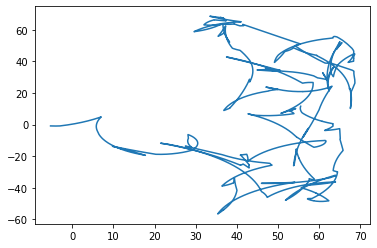

In [9]:
posedata = pandas.read_csv(f'data/{folder}.csv')

#convert to cms
pos_x = posedata['field.x']*10.
pos_y = posedata['field.y']*10.

# pos_x = pos_x[::2]
# pos_y = pos_y[::2]

dt = 20
t = np.arange(0,sim_len,dt)*1.
time = [i * 1. for i in t if i < sim_len]

if len(pos_x)< len(time):
    sim_len = time[len(pos_x)]
    t = np.arange(0,sim_len,dt)*1.
    time = [i * 1. for i in t if i < sim_len]
    print(f'Data length = {int(sim_len)}ms = {sim_len / 60000}')

pos_x = np.array(pos_x[:len(time)])
pos_y = np.array(pos_y[:len(time)])
plt.plot(pos_x,pos_y)

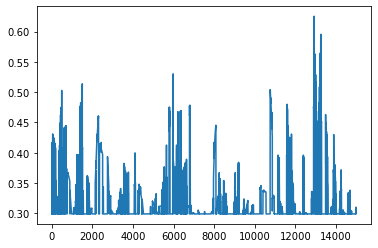

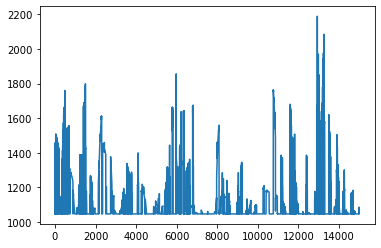

In [10]:
vel_x = np.diff(pos_x)
vel_y = np.diff(pos_y)

sh = 0
go_l,go_r = vel_x,-vel_x
go_u,go_d = vel_y,-vel_y
# go_l, go_r, go_u, go_d = go_l+sh, go_r+sh, go_u+sh, go_d+sh
go_l[go_l<=sh] = 0.
go_r[go_r<=sh] = 0.
go_u[go_u<=sh] = 0.
go_d[go_d<=sh] = 0.

a=.3
go_l, go_r, go_u, go_d = go_l+a, go_r+a, go_u+a, go_d+a
mx = np.max([np.max(go_l),np.max(go_r),np.max(go_u),np.max(go_d)])
go_l, go_r, go_u, go_d = (go_l/mx)*0.7, (go_r/mx)*0.7, (go_u/mx)*0.7, (go_d/mx)*0.7
plt.plot(go_l)

go_l, go_r, go_u, go_d = go_l*3500, go_r*3500, go_u*3500, go_d*3500

plt.figure()
plt.plot(go_l)

l_input = sim.Create('step_current_generator', 1)
sim.SetStatus(l_input,{'amplitude_times': t[1:],'amplitude_values': go_l})
r_input = sim.Create('step_current_generator', 1)
sim.SetStatus(r_input,{'amplitude_times': t[1:],'amplitude_values': go_r})
u_input = sim.Create('step_current_generator', 1)
sim.SetStatus(u_input,{'amplitude_times': t[1:],'amplitude_values': go_u})
d_input = sim.Create('step_current_generator', 1)
sim.SetStatus(d_input,{'amplitude_times': t[1:],'amplitude_values': go_d})

In [11]:
sim.Connect(l_input,l,'all_to_all')
sim.Connect(r_input,r,'all_to_all')
sim.Connect(u_input,d,'all_to_all')
sim.Connect(d_input,u,'all_to_all')

### Record spikes

THE NUMBER OF CELLS RECORDED IS LIMITED TO JUST 3 HERE

In [12]:
exc_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True})
sim.Connect([exc[10],exc[20],exc[30]],exc_spikes)

### Init bump

In the absence of input from the conjunctive cell populations, the bump of activity maintained by the attractor network remains stationary. The initial position of the activity bump is produced by applying a 300 pA step current for 100 ms to a nominal excitatory cell.

In [13]:
bump_init = sim.Create('step_current_generator', 1, params = {'amplitude_times':[0.1,0.1+I_init_dur],'amplitude_values':[I_init,0.0]})
sim.Connect(bump_init,[exc[I_init_pos]])

### Run simulation

In [14]:
tic = tm.time()
sim.Simulate(sim_len)
print(f'Simulation run time: {np.around(tm.time()-tic,2)}s  Simulated time: {np.around(sim_len/1000,2)}s')

Simulation run time: 1270.33s  Simulated time: 300.0s


In [15]:
if not os.path.exists(f'data/{folder}'):
    os.makedirs(f'data/{folder}')

To plot spikes of one cell on the trajectory, all spike times for each cell are found and subsequently equivalent position on the trajectory at that time point.

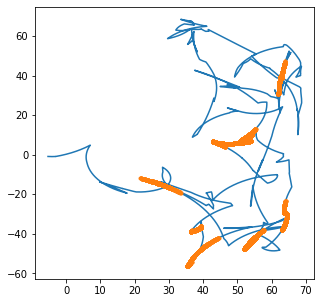

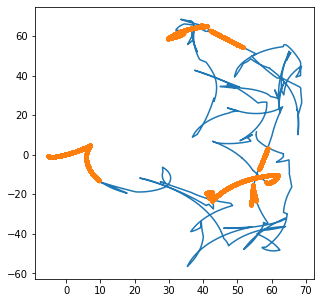

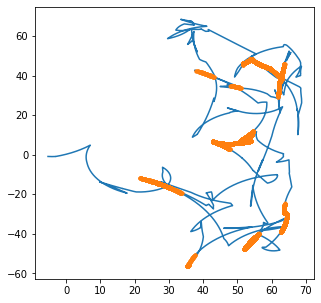

In [16]:
from collections import Counter 
ev = sim.GetStatus(exc_spikes)[0]['events']
t = ev['times']
sp = ev['senders']

for cell in set(sp):
    spktms = t[sp==cell]
    spktms = (spktms//20)*20
    spktms=spktms[1:]

    xs = np.empty((len(spktms)))
    ys = np.empty((len(spktms)))

    for i,spk in enumerate(spktms):
        xs[i] = pos_x[np.where(time == spk)[0][0]]
        ys[i] = pos_y[np.where(time == spk)[0][0]]

    fig = plt.figure(figsize=(5, 5),facecolor='w')
    # plt.plot(x,y)
    plt.plot(pos_x[:len(time)],pos_y[:len(time)])
    plt.plot(xs,ys,'.')
    plt.savefig(f'data/{folder}/cell_{cell}.png')

Spikes must be aranged in a dataframe in order to be compatable with the gridCellAnalysis scripts

In [23]:
prm = dict()
prm['pixel_ratio'] = 440
prm['output_path'] = f'data/{folder}/'
np.save(f'data/{folder}/params.npy',prm)

import pandas as pd
spike_data = pd.DataFrame()
for cell in set(sp):
    spktms = t[sp==cell]
    spktms = (spktms//20)*20

    xs = np.empty((len(spktms)))
    ys = np.empty((len(spktms)))

    for i,spk in enumerate(spktms):
        if spk < 60000:
            xs[i] = pos_x[np.where(time == spk)[0][0]]
            ys[i] = pos_y[np.where(time == spk)[0][0]]

    spike_data = spike_data.append({'cell_id': int(cell),
                                    'spike_times': spktms, 
                                    'number_of_spikes': len(spktms),
                                    'mean_firing_rate': len(spktms)/(sim_len/1000),
                                    'position_x': xs - min(pos_x),
                                    'position_y': ys - min(pos_y),
                                    'position_x_pixels' : (xs - min(pos_x)) / 100 * prm['pixel_ratio'],
                                    'position_y_pixels' : (ys - min(pos_y)) / 100 * prm['pixel_ratio']
                                    }, ignore_index=True)
spike_data.to_pickle(f'data/{folder}/spike_data.pkl')

In [24]:
spatial_data = dict()
spatial_data['position_x'] = pos_x - min(pos_x)
spatial_data['position_y'] = pos_y - min(pos_y)

# pixels = cm / 100 * prm['pixel_ratio']
spatial_data['position_x_pixels'] = spatial_data['position_x'] / 100 * prm['pixel_ratio']
spatial_data['position_y_pixels'] = spatial_data['position_y'] / 100 * prm['pixel_ratio']

spatial_data = pd.DataFrame.from_dict(spatial_data)
spatial_data.to_pickle(f'data/{folder}/spatial_data.pkl')

I will plot a heat map of the position of the animal to show coverage.


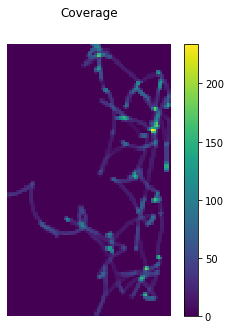

In [25]:
position_heat_map = griddy.get_position_heatmap(spatial_data, prm)
griddy.plot_coverage(position_heat_map, prm)

In [26]:
if not 'firing_maps' in spike_data:
    position_heat_map, spike_data = griddy.make_firing_field_maps(spatial_data, spike_data, prm)

I will calculate firing rate maps now.
Started another cluster
0
Started another cluster
1
Started another cluster
2
Making the rate maps took:
44.3198766708374


I will make rate map plots.


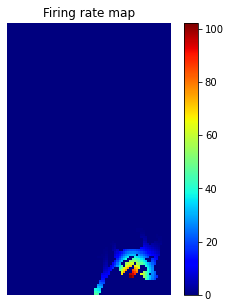

In [27]:
# plot firing rate maps
griddy.plot_firing_rate_maps(spike_data, prm)

In [ ]:
# spike_data = griddy.process_grid_data(spike_data)
# path = prm['output_path']
# spike_data.to_pickle(f'{path}spikeData_withGridMetrics.pkl')